In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
stations = Base.classes.station
measurement = Base.classes.measurement
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [8]:
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [44]:
# Find the most recent date in the data set.
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()
most_recent

('2017-08-23',)

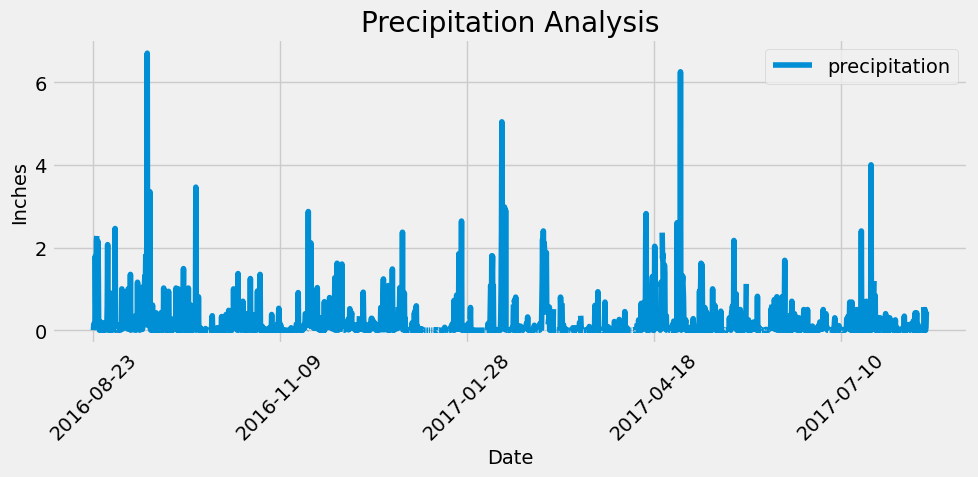

In [19]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
sel = [measurement.date, measurement.prcp, measurement.id]
last_12 = session.query(*sel).\
    filter(measurement.date >= '2016-08-23').\
    order_by(measurement.date).all()
# Calculate the date one year from the last date in data set.
year_ago = dt.date(2017, 8, 23) - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
preceip_scores = session.query(measurement.date, measurement.prcp).\
    filter(measurement.date >= year_ago).\
    order_by(measurement.date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(preceip_scores, columns=['date', 'precipitation'])

# Sort the dataframe by date
precip_df.set_index('date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
plot = precip_df.plot(figsize=(10,5))
plot.set_title("Precipitation Analysis")
plot.set_ylabel('Inches')
plot.set_xlabel('Date')
plt.xticks(rotation=45)
plt.tight_layout()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
precip_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [23]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(stations.station).count()
total_stations
    

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).\
    order_by(func.count(measurement.station).desc()).all()
active_stations


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
start_date = '2016-01-30'
end_date = '2016-01-29'  
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_temps = session.query(*sel).\
filter(measurement.station >= start_date).\
filter(measurement.station >= end_date).all()
session.close()
most_active_temps

[(53.0, 87.0, 73.09795396419437)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active = active_stations[0][0]
sel = [func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)]
most_active_temps = session.query(*sel).\
    filter(measurement.station == most_active).all()
most_active_temps

[(54.0, 85.0, 71.66378066378067)]

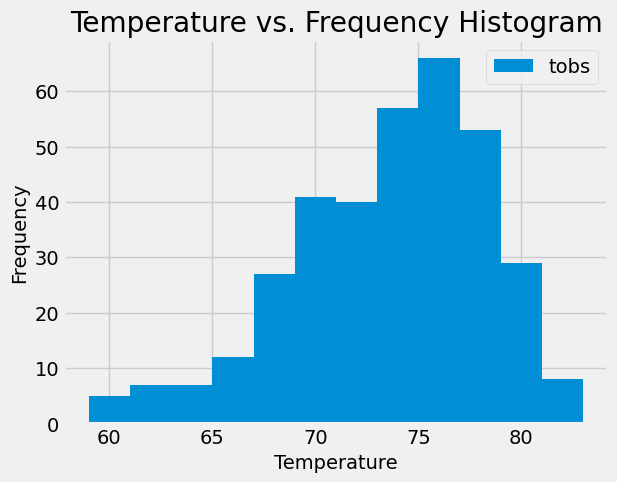

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
most_active_year = session.query(measurement.tobs).\
    filter(measurement.station == most_active).\
    filter(measurement.date >= year_ago).all()
most_active_year_df = pd.DataFrame(most_active_year, columns=['tobs'])
most_active_year_df.plot.hist(bins=12, title="Temperature vs. Frequency Histogram")
plt.tight_layout()
plt.xlabel("Temperature")
plt.legend(loc="upper right")
plt.show()

# Close Session

In [17]:
# Close Session
session.close()